# 2. CML processing 
In this notebook cml are processed according to the following steps:
* calculate total loss
* simple quality control
* Wet&Dry Classification
* baseline computation 
* rain-induced attenuation
* rain rate estimate

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pycomlink as pycml
import pandas as pd
from scipy.ndimage import binary_dilation

## 2.1 functions: CML processing + plot

In [2]:
def cml_preprocessing(ds_cmls_input):
    '''
    compute total loss and remove poorly performing cmls
    '''
    ds_cmls = ds_cmls_input.copy()

    # calculate total loss
    ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

    # flag cmls with strong diurnal cycles
    qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1
    
    # flag cmls with very noisy periods
    qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.35

    filtered = ds_cmls.where(qc_diurnalcicle | qc_noisyperiods, drop=True)
    ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)
    ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)
    
    return ds_cmls, filtered

In [3]:
def wetdry_radarbased(ds_cmls, radar_along_cml, rad_freq):
   '''
   perform wet/dry classification based on rad_freq min radar rainfall along cml
   '''
   # preparation of the datasets
   timeseq = pd.date_range(ds_cmls.time.values[0], ds_cmls.time.values[-1], freq="min")
   ds_cmls = ds_cmls.reindex({"time": timeseq})
   radar_along_cml = radar_along_cml.transpose("cml_id", "time")
   radar_along_cml = radar_along_cml.reindex({"time": timeseq})
   radar_along_cml = radar_along_cml.reindex({"cml_id": ds_cmls.cml_id})
   #initialize
   wet = xr.zeros_like(ds_cmls["tl"], dtype=bool)
   # create mask == True when radar > 0.01
   radar_along_cml['mask'] = (radar_along_cml.rainfall_amount > 0.01).astype('int')
   #expand mask rad_freq min before and 5 min after
   expand_ones = rad_freq + 5
   mask_np = radar_along_cml.mask.values
   # expansion with binary_dilation on rows(cml_id)
   expanded_mask_np = np.array([
      binary_dilation(row, structure=np.ones(expand_ones), origin=int(expand_ones/2-6))
      for row in mask_np
   ])
   expanded_mask_xr = xr.DataArray(expanded_mask_np.astype(int), 
                                   coords=radar_along_cml.mask.coords, 
                                   dims=radar_along_cml.mask.dims)
   wet.loc[{"sublink_id": ["channel1","channel2"]}] = expanded_mask_xr
   return wet 

In [4]:
def cml_processing(ds_cmls_input, radar_along_cml, rad_freq):
    '''
    cml processing
    '''
    ds_cmls = ds_cmls_input.copy()

    # calculate wet periods
    ds_cmls['wet'] = wetdry_radarbased(ds_cmls, radar_along_cml, rad_freq)
    
    # calculate baseline
    ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
        trsl=ds_cmls.tl,
        wet=ds_cmls.wet,
        n_average_last_dry=5,
    )    

    # calculate wet antenna effect
    ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
    ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
    ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
        A_obs=ds_cmls.A_obs,
        f_Hz=ds_cmls.frequency * 1e6,
        pol=ds_cmls.polarization.data,
        L_km=ds_cmls.length / 1000,
        A_max=6,
        zeta=0.7,  
        d=0.15, 
    )
    
    # calculate attenuation caused by rain and remove negative attenuation
    ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
    ds_cmls["A"].data[ds_cmls.A < 0] = 0
    # derive rain rate via the k-R relation
    ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
        A=ds_cmls.A,
        L_km=ds_cmls.length.astype(float) / 1000,  
        f_GHz=ds_cmls.frequency / 1000,  
        pol=ds_cmls.polarization,
    )
    
    #calculate 1minute acc. precipitation  
    ds_cmls['R_acc'] = ds_cmls['R']/60
    return ds_cmls

In [5]:
def plot_filtered_cmls(filtered):
    fig, ax=plt.subplots(1,3, figsize=(15,5))
    for i in np.arange(3):
        filtered.tl.isel(cml_id=i).plot.line(x='time', ax=ax[i], alpha=0.8) 
        ax[i].set_title('ID: '+str(filtered.cml_id.values[i]))
        ax[i].set_ylabel('')
    ax[0].set_ylabel('Attenuation Level')
    plt.suptitle(str(len(filtered.cml_id))+' CMLs removed. Examples:')
    plt.show()

In [6]:
def checkplot_cml_radar(ds_cmls, radar_along_cml):
    cmls_plot = ds_cmls.R_acc.resample(time = '15min', label='right', closed='right').sum()
    cmls_plot = cmls_plot.reduce(np.nanmean, dim='sublink_id')
    rad_plot = radar_along_cml.rainfall_amount.resample(time = '15min', label='right', closed='right').sum()
    
    # reindex on the same time and cml_id
    cmls_plot=cmls_plot.transpose("cml_id", "time").reset_coords(drop=True)
    rad_plot=rad_plot.transpose("cml_id", "time").reset_coords(drop=True)
    common_time = xr.concat([cmls_plot['time'], rad_plot['time']], dim='time').drop_duplicates('time')
    common_cml_id = xr.concat([cmls_plot['cml_id'], rad_plot['cml_id']], dim='cml_id').drop_duplicates('cml_id')
    cmls_plot = cmls_plot.reindex(time=common_time, cml_id=common_cml_id)
    rad_plot = rad_plot.reindex(time=common_time, cml_id=common_cml_id)
    cml_id_i = cmls_plot.isel(cml_id=0)
    rad_id_i = rad_plot.isel(cml_id=0)
    cmls_plot = cmls_plot.values.flatten()
    rad_plot = rad_plot.values.flatten()
    
    #ignore NaN to avoide warnings
    mask = ~np.isnan(cmls_plot) & ~np.isnan(rad_plot)
    
    fig, ax=plt.subplots(1,2, figsize=(11,5))
    ax[0].hexbin(
        cmls_plot[mask],
        rad_plot[mask],
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[0].text(
        0.75,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((rad_plot[mask] - cmls_plot[mask]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[0].transAxes,
    )
    ax[0].text(
        0.75,
        0.12,
        "PCC: " + str(round(np.corrcoef(rad_plot[mask], cmls_plot[mask])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[0].transAxes,
    )
    ax[0].text(
        0.75,
        0.21,
        "bias: "
        + str(round(np.mean(cmls_plot[mask] - rad_plot[mask]) / np.mean(rad_plot[mask]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[0].transAxes,
    )
    ax[0].text(
        0.75,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(cmls_plot[mask] - rad_plot[mask])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[0].transAxes,
    )
    ax[0].set_xlabel('cmls acc. rainfall over 15 minutes [mm]')
    ax[0].set_ylabel('radar acc. rainfall over 15 minutes [mm]')
    ax[0].grid(color='gray', linestyle='--', alpha=0.8)
    ax[0].plot([0,10], [0,10], ls="-", c="black", lw=0.5)
    cml_id_i.plot.line(ax=ax[1], x='time', label='cml')
    rad_id_i.plot.line(ax=ax[1], x='time', label='radar', alpha=0.6)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Acc. rainfall over 15 minutes [mm]')
    ax[1].grid(color='gray', linestyle='--', alpha=0.8)
    ax[1].legend()
    plt.show()


## 2.2 OpenMRG processing

In [7]:
#open dataset
ds_cmls = xr.open_dataset('data/andersson_2022_OpenMRG/openMRG_cml.nc')
radar_along_cml = xr.open_dataset('data/andersson_2022_OpenMRG/radar/radar_along_cml.nc')
rad_freq=5 # radar data frequency [minute]

In [8]:
# Resample to 1 minute temporal resolution
ds_cmls = ds_cmls.resample(time="1min").first(skipna=True)
# change sublink identifiers names 
ds_cmls = ds_cmls.assign_coords(sublink_id = np.array(['channel1', 'channel2'])) 
# convert mm/h -> mm in 5 minutes
radar_along_cml['rainfall_amount'] = radar_along_cml['rainfall_amount']/12

In [9]:
# compute attenuation + QC
ds_cmls, filtered = cml_preprocessing(ds_cmls)

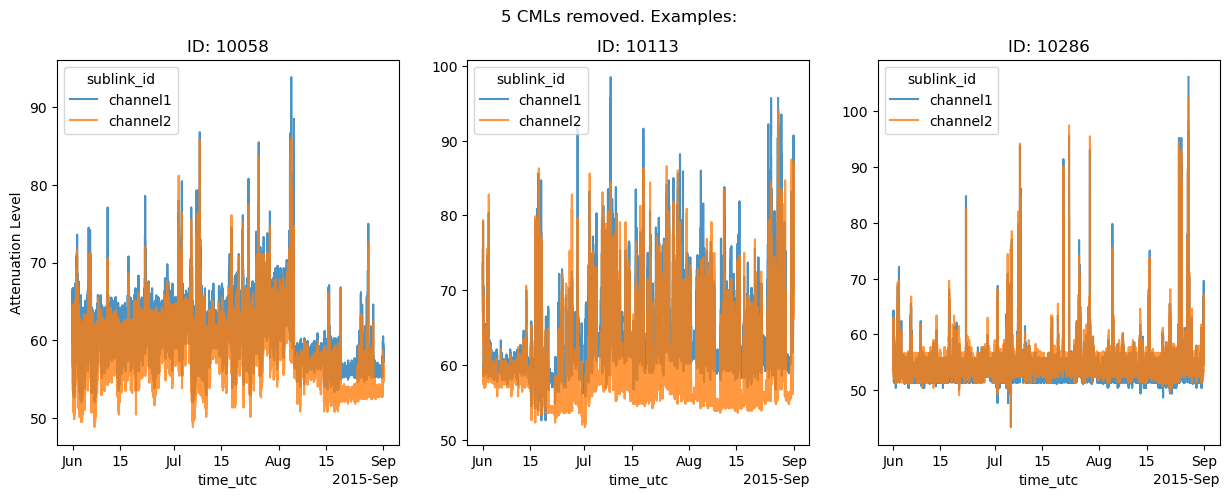

In [10]:
# plot 
plot_filtered_cmls(filtered)

In [11]:
# cml processing
ds_cmls = cml_processing(ds_cmls, radar_along_cml, rad_freq) 

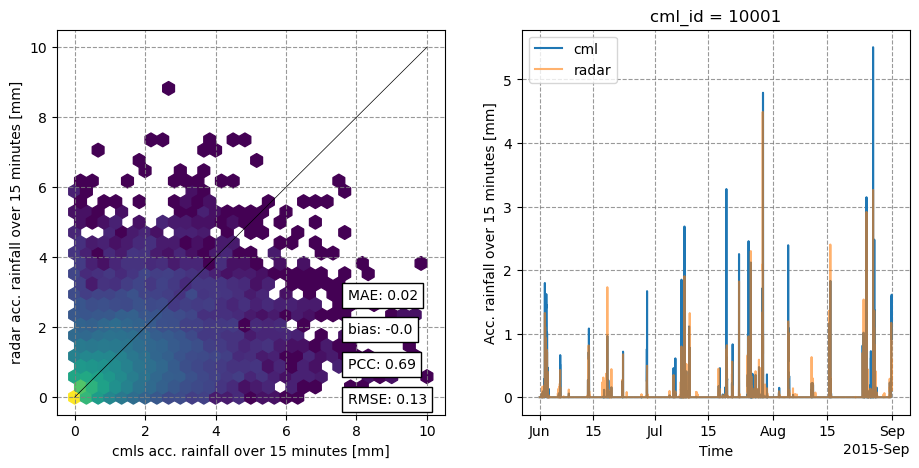

In [12]:
# plot 
checkplot_cml_radar(ds_cmls, radar_along_cml)

In [13]:
# saving output
ds_cmls.to_netcdf('data/processed_cml_OpenMRG.nc')

## 2.3 OpenRainER processing

In [14]:
#open dataset
ds_cmls = xr.open_dataset('data/covi_2024_OpenRainER/OpenRainER_cmls.nc')
radar_along_cml = xr.open_dataset('data/covi_2024_OpenRainER/RADadj_along_cml.nc')
rad_freq=15 # radar data frequency [minute]

In [15]:
# compute attenuation + QC
ds_cmls, filtered = cml_preprocessing(ds_cmls)

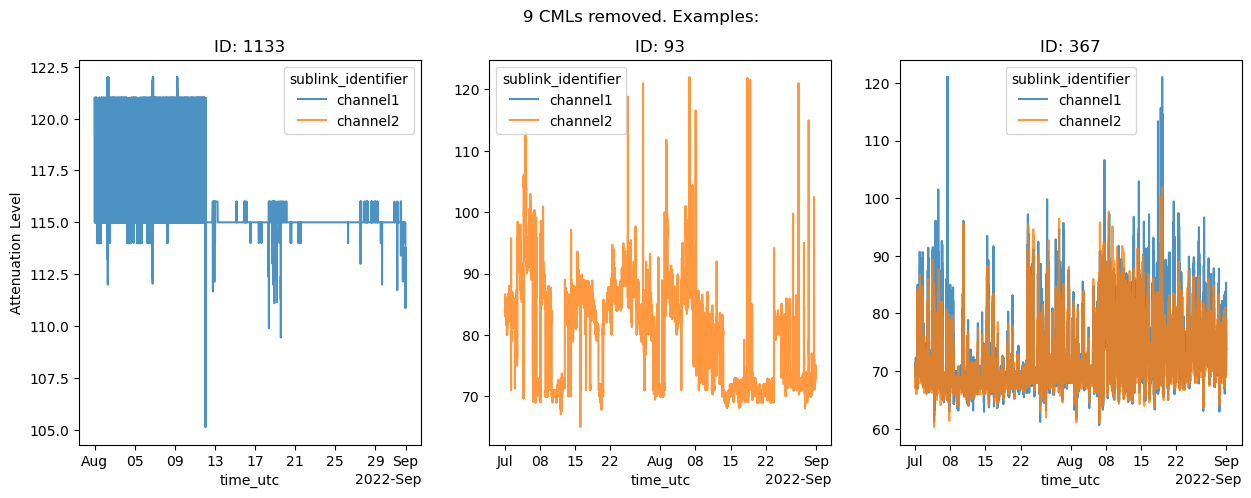

In [16]:
# plot 
plot_filtered_cmls(filtered)

In [17]:
# cml processing
ds_cmls = cml_processing(ds_cmls, radar_along_cml, rad_freq) 

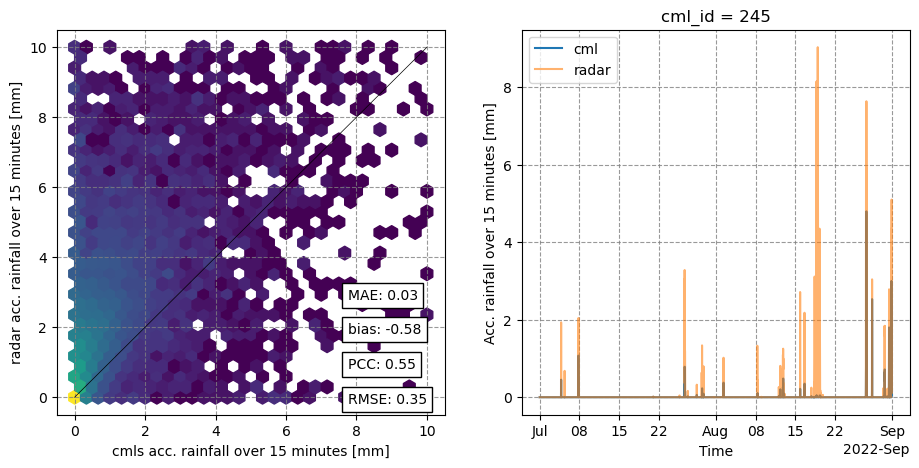

In [18]:
# plot 
checkplot_cml_radar(ds_cmls, radar_along_cml)

In [19]:
# saving output
ds_cmls.to_netcdf('data/processed_cml_OpenRainER.nc')